# Chapter 5. The Many Variables & The Spurious Waffles

In [125]:
import sys
!{sys.executable} -m pip install -U numpyro arviz causalgraphicalmodels daft networkx graphviz

Requirement already up-to-date: numpyro in /usr/local/lib/python3.7/site-packages (0.6.0)
Requirement already up-to-date: arviz in /usr/local/lib/python3.7/site-packages (0.11.2)
Requirement already up-to-date: causalgraphicalmodels in /usr/local/lib/python3.7/site-packages (0.0.4)
Requirement already up-to-date: daft in /usr/local/lib/python3.7/site-packages (0.1.2)
     |████████████████████████████████| 1.6MB 1.2MB/s eta 0:00:01
Requirement already up-to-date: graphviz in /usr/local/lib/python3.7/site-packages (0.16)
ERROR: deepposekit 0.3.7 requires opencv-python, which is not installed.
ERROR: sleap 1.0.0 has requirement PySide2<=5.14.1,>=5.12.0, but you'll have pyside2 5.14.2.1 which is incompatible.
  Found existing installation: networkx 2.3
    Uninstalling networkx-2.3:
      Successfully uninstalled networkx-2.3


In [40]:
import math
import os

import arviz as az
import daft
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel

import jax
import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, NUTS, MCMC, RenyiELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")

### Code 5.1

In [31]:
# load data and copy
WaffleDivorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
d = WaffleDivorce

# standardize variables
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())


In [32]:
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,A,D
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,1.654205
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699,1.544364
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241,0.610716
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387,2.093569
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.599857,-0.927058


### Figure 5.1

In [33]:
d["WHpM"] = d["WaffleHouses"] / d["Population"]

In [34]:
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,A,D,WHpM
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,1.654205,26.778243
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699,1.544364,0.000000
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241,0.610716,2.843602
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387,2.093569,14.041096
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.599857,-0.927058,0.000000


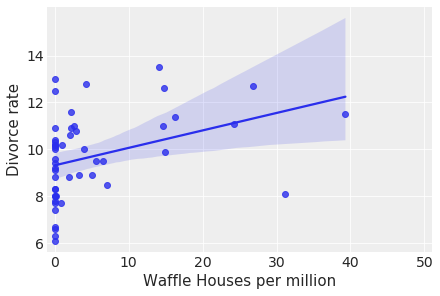

In [35]:
ax = sns.regplot(x="WHpM", y="Divorce", data=d)
ax.set_xlabel("Waffle Houses per million")
ax.set_xlim(-1, 51)
ax.set_xticks([0, 10, 20, 30, 40, 50])
ax.set_ylabel("Divorce rate")
ax.set_yticks([6, 8, 10, 12, 14])
plt.show()

### Code 5.2

In [36]:
d.MedianAgeMarriage.std()

1.2436303013880823

In [37]:
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,A,D,WHpM
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,1.654205,26.778243
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699,1.544364,0.000000
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241,0.610716,2.843602
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387,2.093569,14.041096
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.599857,-0.927058,0.000000


### Code 5.2

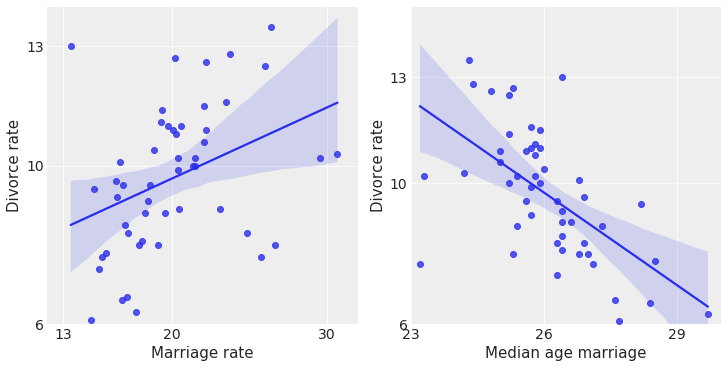

In [38]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.regplot(x="Marriage", y="Divorce", data=d, ax=ax1)
ax1.set_xlabel("Marriage rate")
ax1.set_xlim(12, 32)
ax1.set_xticks([13, 20, 30])
ax1.set_ylabel("Divorce rate")
ax1.set_ylim(6, 14)
ax1.set_yticks([6, 10, 13])

sns.regplot(x="MedianAgeMarriage", y="Divorce", data=d, ax=ax2)
ax2.set_xlabel("Median age marriage")
ax2.set_xlim(23, 30)
ax2.set_xticks([23, 26, 29])
ax2.set_ylabel("Divorce rate")
ax2.set_ylim(6, 15)
ax2.set_yticks([6, 10, 13])

plt.show()

### Code 5.3

In [71]:
def model(A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bA * A)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_1 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_1, optim.Adam(1), RenyiELBO(0.001, num_particles=1024), A=d.A.values, D=d.D.values)
p5_1, losses = svi.run(random.PRNGKey(0), 1000)

100%|██████████| 1000/1000 [00:01<00:00, 846.75it/s, init loss: 2138.6682, avg. loss [951-1000]: 60.6515]


### Code 5.4

In [72]:
predictive = Predictive(m5_1.model, num_samples=1000, return_sites=["mu"])
prior_pred = predictive(random.PRNGKey(10), A=jnp.array([-2, 2]))

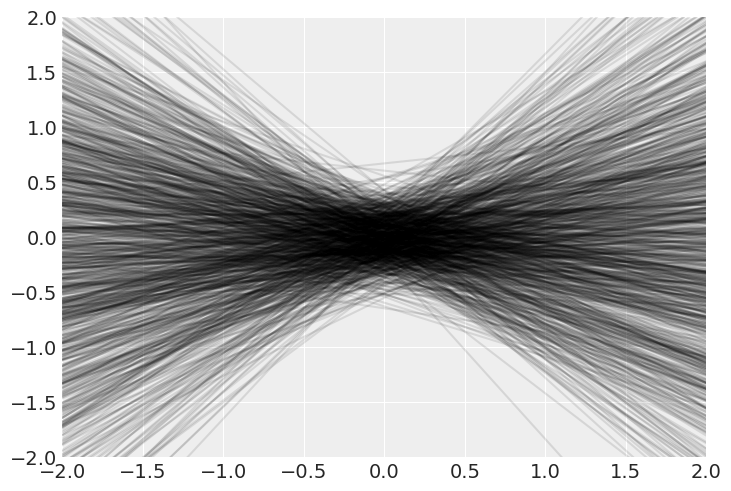

In [73]:
mu = prior_pred["mu"]
plt.subplot(xlim=(-2, 2), ylim=(-2, 2))
for i in range(1000):
    plt.plot([-2, 2], mu[i], "k", alpha=0.1)

### Code 5.5

In [74]:
A_seq = jnp.linspace(start=-3, stop=3.2, num=30)
post = m5_1.sample_posterior(random.PRNGKey(1), p5_1, (10000,))


In [75]:
d.shape

(50, 16)

In [76]:
post_pred = Predictive(m5_1.model, post)(random.PRNGKey(2), A=A_seq)


In [77]:
post_pred.keys()

dict_keys(['D', 'mu'])

In [78]:
post_pred["D"].shape

(10000, 30)

In [79]:
# compute percentile interval of mean
mu = post_pred["mu"]
mu_mean = jnp.median(mu, axis=0)

In [80]:
mu_mean.shape

(30,)

In [81]:
mu_PI = jnp.percentile(mu, q=(50, 5.5, 94.5), axis=0)

In [82]:
mu_PI.shape

(3, 30)

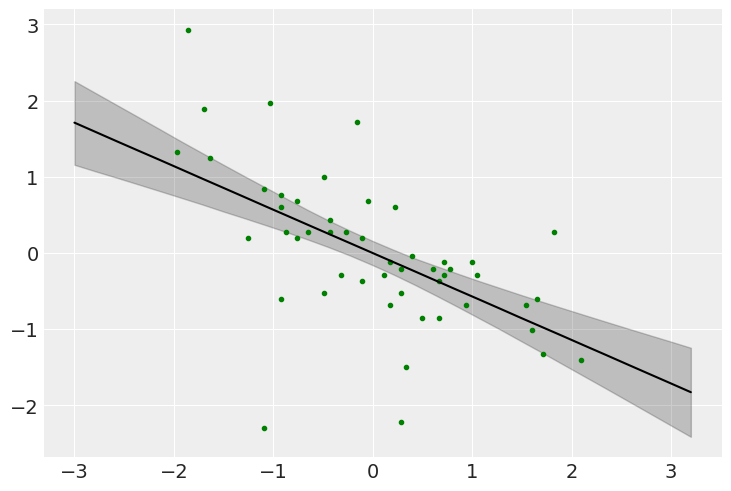

In [83]:
# plot it all
#az.plot_pair(d[["D", "A"]].to_dict(orient="list"))

plt.plot(d["D"].values, d["A"].values, 'g.')
plt.plot(A_seq, mu_PI[0], "k-")
plt.fill_between(A_seq, mu_PI[1], mu_PI[2], color="k", alpha=0.2)
plt.show()

In [84]:
D = post_pred["D"]
D.shape

(10000, 30)

In [85]:
D_PI = jnp.percentile(D, q=(50, 5.5, 94.5), axis=0)

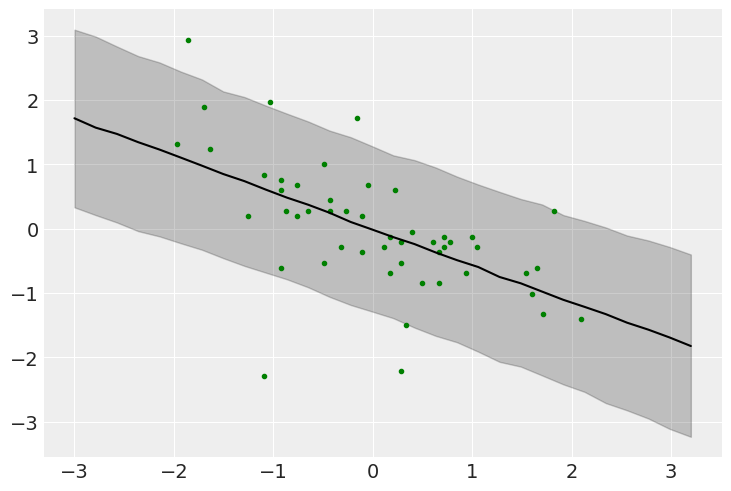

In [86]:
# plot it all
#az.plot_pair(d[["D", "A"]].to_dict(orient="list"))
plt.plot(d["D"].values, d["A"].values, 'g.')
plt.plot(A_seq, D_PI[0], "k-")
plt.fill_between(A_seq, D_PI[1], D_PI[2], color="k", alpha=0.2)
plt.show()

### Code 5.6

In [33]:
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())


def model(M, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_2, optim.Adam(1), Trace_ELBO(), M=d.M.values, D=d.D.values)
p5_2, losses = svi.run(random.PRNGKey(0), 1000)

100%|██████████| 1000/1000 [00:01<00:00, 999.46it/s, init loss: 962.7464, avg. loss [951-1000]: 67.4809]


### Code 5.7

In [27]:
dag5_1 = CausalGraphicalModel(
    nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")]
)
dag5_1.draw()


ExecutableNotFound: failed to execute ['dot', '-Kdot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

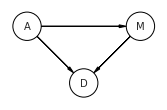

In [28]:
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
with plt.rc_context({"figure.constrained_layout.use": False}):
    pgm.render()
plt.gca().invert_yaxis()

### Code 5.8

In [9]:
DMA_dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('M', 'D', {'A'})


### Code 5.9

In [10]:
DMA_dag2 = CausalGraphicalModel(
    nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")]
)
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

### Code 5.10

In [32]:
def model(M, A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bM * M + bA * A)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_3 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_3, optim.Adam(1), Trace_ELBO(), M=d.M.values, A=d.A.values, D=d.D.values)
p5_3, losses = svi.run(random.PRNGKey(0), 1000)
post = m5_3.sample_posterior(random.PRNGKey(1), p5_3, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:01<00:00, 788.86it/s, init loss: 3201.7393, avg. loss [951-1000]: 60.7879]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.00      0.10     -0.01     -0.16      0.14   1049.96      1.00
        bA     -0.61      0.16     -0.61     -0.86     -0.36    822.38      1.00
        bM     -0.06      0.16     -0.06     -0.31      0.19    984.99      1.00
     mu[0]      0.36      0.13      0.37      0.15      0.57    921.63      1.00
     mu[1]      0.32      0.21      0.32     -0.01      0.66    900.77      1.00
     mu[2]      0.12      0.10      0.12     -0.03      0.28    995.35      1.00
     mu[3]      0.76      0.21      0.75      0.43      1.10    911.65      1.00
     mu[4]     -0.35      0.12     -0.35     -0.52     -0.14   1070.56      1.00
     mu[5]      0.12      0.15      0.12     -0.13      0.35    861.01      1.00
     mu[6]     -0.71      0.17     -0.70     -0.95     -0.42   1053.26      1.00
     mu[7]     -0.31      0.20     -0.32     -0.63      0.03    865.14      1.00
     mu[8]     -1.74      0

### Code 5.11

In [55]:
coeftab = {
    "m5.1": m5_1.sample_posterior(random.PRNGKey(1), p5_1, (1, 1000,)),
    "m5.2": m5_2.sample_posterior(random.PRNGKey(2), p5_2, (1, 1000,)),
    "m5.3": m5_3.sample_posterior(random.PRNGKey(3), p5_3, (1, 1000,)),
}


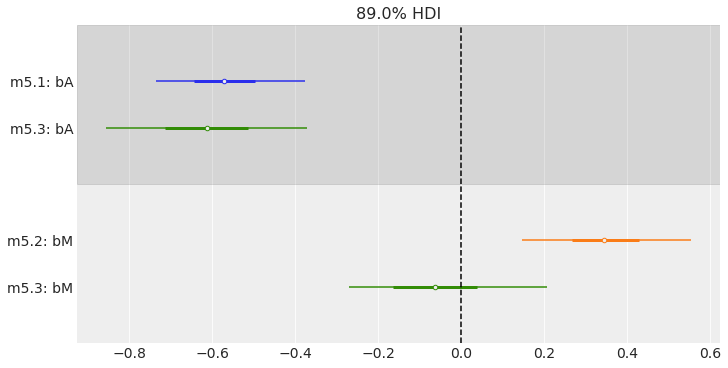

In [66]:
az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    var_names=["bA", "bM"],
    hdi_prob=0.89,
    figsize=(10,5)
)
plt.axvline(x=0, color="k", linestyle="--")
plt.show()

### Code 5.12

In [13]:
N = 50  # number of simulated States
age = dist.Normal().sample(random.PRNGKey(0), sample_shape=(N,))  # sim A
mar = dist.Normal(age).sample(random.PRNGKey(1))  # sim A -> M
div = dist.Normal(age).sample(random.PRNGKey(2))  # sim A -> D

### Code 5.13

In [67]:
def model(A, M=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bAM = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bAM * A)
    numpyro.sample("M", dist.Normal(mu, sigma), obs=M)


m5_4 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_4, optim.Adam(0.1), Trace_ELBO(), A=d.A.values, M=d.M.values)
p5_4, losses = svi.run(random.PRNGKey(0), 1000)

100%|██████████| 1000/1000 [00:01<00:00, 955.39it/s, init loss: 2288.6685, avg. loss [951-1000]: 53.6926]


### Code 5.14

In [71]:
post = m5_4.sample_posterior(random.PRNGKey(1), p5_4, (1000,))
post_pred = Predictive(m5_4.model, post)(random.PRNGKey(2), A=d.A.values)
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_resid = d.M.values - mu_mean

### Code 5.15

In [72]:
# call predictive without specifying new data
# so it uses original data
post = m5_3.sample_posterior(random.PRNGKey(1), p5_3, (int(1e4),))
post_pred = Predictive(m5_3.model, post)(random.PRNGKey(2), M=d.M.values, A=d.A.values)
mu = post_pred["mu"]

# summarize samples across cases
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=(5.5, 94.5), axis=0)

# simulate observations
# again no new data, so uses original data
D_sim = post_pred["D"]
D_PI = jnp.percentile(D_sim, q=(5.5, 94.5), axis=0)

### Code 5.17

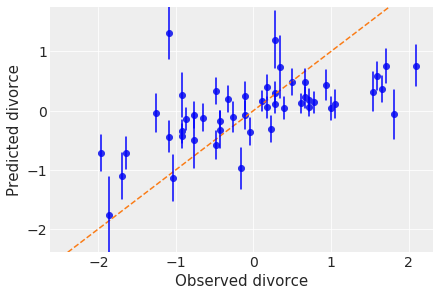

In [17]:
ax = plt.subplot(
    ylim=(float(mu_PI.min()), float(mu_PI.max())),
    xlabel="Observed divorce",
    ylabel="Predicted divorce",
)
plt.plot(d.D, mu_mean, "o")
x = jnp.linspace(mu_PI.min(), mu_PI.max(), 101)
plt.plot(x, x, "--")
for i in range(d.shape[0]):
    plt.plot([d.D[i]] * 2, mu_PI[:, i], "b")
fig = plt.gcf()

### Code 5.17

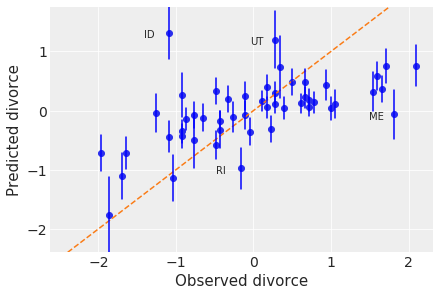

In [18]:
for i in range(d.shape[0]):
    if d.Loc[i] in ["ID", "UT", "RI", "ME"]:
        ax.annotate(
            d.Loc[i], (d.D[i], mu_mean[i]), xytext=(-25, -5), textcoords="offset pixels"
        )
fig

### Code 5.18

In [19]:
N = 100  # number of cases
# x_real as Gaussian with mean 0 and stddev 1
x_real = dist.Normal().sample(random.PRNGKey(0), (N,))
# x_spur as Gaussian with mean=x_real
x_spur = dist.Normal(x_real).sample(random.PRNGKey(1))
# y as Gaussian with mean=x_real
y = dist.Normal(x_real).sample(random.PRNGKey(2))
# bind all together in data frame
d = pd.DataFrame({"y": y, "x_real": x_real, "x_spur": x_spur})

### Code 5.19

In [73]:
WaffleDivorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
d = WaffleDivorce
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())


def model(A, M=None, D=None):
    # A -> M
    aM = numpyro.sample("aM", dist.Normal(0, 0.2))
    bAM = numpyro.sample("bAM", dist.Normal(0, 0.5))
    sigma_M = numpyro.sample("sigma_M", dist.Exponential(1))
    mu_M = aM + bAM * A
    M = numpyro.sample("M", dist.Normal(mu_M, sigma_M), obs=M)
    
    # A -> D <- M
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M + bA * A
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_3_A = AutoLaplaceApproximation(model)
svi = SVI(
    model, m5_3_A, optim.Adam(0.1), Trace_ELBO(), A=d.A.values, M=d.M.values, D=d.D.values
)
p5_3_A, losses = svi.run(random.PRNGKey(0), 1000)

100%|██████████| 1000/1000 [00:01<00:00, 574.37it/s, init loss: 10480.9580, avg. loss [951-1000]: 114.4805]


### Code 5.20

In [75]:
A_seq = jnp.linspace(-2, 2, num=30)

### Code 5.21

In [80]:
# prep data
sim_dat = dict(A=A_seq)

# simulate M and then D, using A_seq
post = m5_3_A.sample_posterior(random.PRNGKey(1), p5_3_A, (1000,))
s = Predictive(m5_3_A.model, post)(random.PRNGKey(2), **sim_dat)

In [78]:
s.keys()

dict_keys(['D', 'M'])

In [79]:
s["D"].shape

(1000, 30)

### Code 5.22

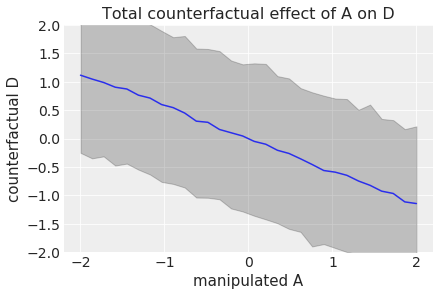

In [91]:
fig, ax1 = plt.subplots()
plt.plot(sim_dat["A"], jnp.mean(s["D"], 0))
plt.gca().set(ylim=(-2, 2), xlabel="manipulated A", ylabel="counterfactual D")
plt.fill_between(
    sim_dat["A"], *jnp.percentile(s["D"], q=(5.5, 94.5), axis=0), color="k", alpha=0.2
)
plt.title("Total counterfactual effect of A on D")
plt.show()

### Code 5.23

In [24]:
# new data frame, standardized to mean 26.1 and stddev 1.24
sim2_dat = dict(A=(jnp.array([20, 30]) - 26.1) / 1.24)
s2 = Predictive(m5_3_A.model, post, return_sites=["M", "D"])(
    random.PRNGKey(2), **sim2_dat
)
jnp.mean(s2["D"][:, 1] - s2["D"][:, 0])

DeviceArray(-4.6818223, dtype=float32)

### Code 5.24

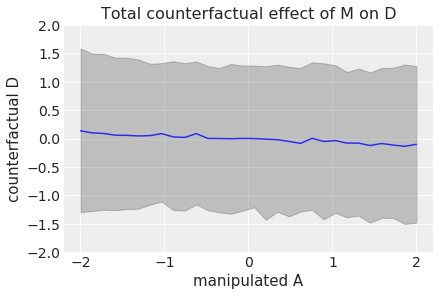

In [92]:
sim_dat = dict(M=jnp.linspace(-2, 2, num=30), A=0)
s = Predictive(m5_3_A.model, post)(random.PRNGKey(2), **sim_dat)["D"]

plt.plot(sim_dat["M"], jnp.mean(s, 0))
plt.gca().set(ylim=(-2, 2), xlabel="manipulated A", ylabel="counterfactual D")
plt.fill_between(
    sim_dat["M"], *jnp.percentile(s, q=(5.5, 94.5), axis=0), color="k", alpha=0.2
)
plt.title("Total counterfactual effect of M on D")
plt.show()

### Code 5.25

In [26]:
A_seq = jnp.linspace(-2, 2, num=30)

### Code 5.26

In [27]:
post = m5_3_A.sample_posterior(random.PRNGKey(1), p5_3_A, (1000,))
post = {k: v[..., None] for k, v in post.items()}
M_sim = dist.Normal(post["aM"] + post["bAM"] * A_seq).sample(random.PRNGKey(1))

### Code 5.27

In [28]:
D_sim = dist.Normal(post["a"] + post["bA"] * A_seq + post["bM"] * M_sim).sample(
    random.PRNGKey(1)
)

### Code 5.28

In [28]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
clade             29 non-null object
species           29 non-null object
kcal.per.g        29 non-null float64
perc.fat          29 non-null float64
perc.protein      29 non-null float64
perc.lactose      29 non-null float64
mass              29 non-null float64
neocortex.perc    17 non-null float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### Code 5.29

In [29]:
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d["N"] = d["neocortex.perc"].pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.mass.map(math.log).pipe(lambda x: (x - x.mean()) / x.std())

### Code 5.30

In [30]:
def model(N, K):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bN = numpyro.sample("bN", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bN * N
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


with numpyro.validation_enabled():
    try:
        m5_5_draft = AutoLaplaceApproximation(model)
        svi = SVI(model, m5_5_draft, optim.Adam(1), Trace_ELBO(), N=d.N.values, K=d.K.values)
        p5_5_draft, losses = svi.run(random.PRNGKey(0), 1000)
    except ValueError as e:
        print(str(e))

Normal distribution got invalid loc parameter.


### Code 5.31

In [96]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

### Code 5.32

In [97]:
dcc = d.iloc[d[["K", "N", "M"]].dropna(how="any", axis=0).index]

### Code 5.33

In [98]:
def model(N, K=None):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bN = numpyro.sample("bN", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bN * N)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m5_5_draft = AutoLaplaceApproximation(model)
svi = SVI(model, m5_5_draft, optim.Adam(0.1), Trace_ELBO(), N=dcc.N.values, K=dcc.K.values)
p5_5_draft, losses = svi.run(random.PRNGKey(0), 1000)

100%|██████████| 1000/1000 [00:00<00:00, 1048.26it/s, init loss: 411.1621, avg. loss [951-1000]: 27.4243]


### Code 5.34

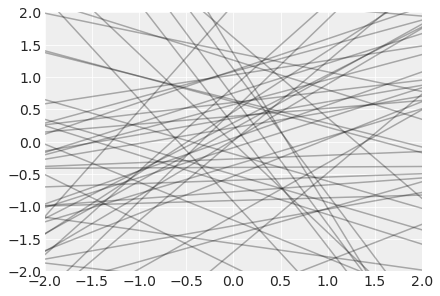

In [99]:
xseq = jnp.array([-2, 2])
prior_pred = Predictive(model, num_samples=1000)(random.PRNGKey(1), N=xseq)
mu = prior_pred["mu"]
plt.subplot(xlim=xseq, ylim=xseq)
for i in range(50):
    plt.plot(xseq, mu[i], "k", alpha=0.3)

### Code 5.35

In [100]:
def model(N, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bN = numpyro.sample("bN", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bN * N)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m5_5 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_5, optim.Adam(1), Trace_ELBO(), N=dcc.N.values, K=dcc.K.values)
p5_5, losses = svi.run(random.PRNGKey(0), 1000)

100%|██████████| 1000/1000 [00:00<00:00, 1045.87it/s, init loss: 414.1050, avg. loss [951-1000]: 25.1957]


### Code 5.36

In [101]:
post = m5_5.sample_posterior(random.PRNGKey(1), p5_5, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.05      0.16      0.05     -0.21      0.29    931.50      1.00
        bN      0.13      0.23      0.13     -0.21      0.53   1111.88      1.00
     mu[0]     -0.22      0.51     -0.22     -0.99      0.60    911.65      1.00
     mu[1]     -0.02      0.20     -0.01     -0.36      0.27    906.66      1.00
     mu[2]     -0.02      0.20     -0.01     -0.36      0.27    906.66      1.00
     mu[3]      0.05      0.16      0.05     -0.21      0.29    931.28      1.00
     mu[4]      0.08      0.17      0.08     -0.18      0.36    940.50      1.00
     mu[5]     -0.14      0.38     -0.13     -0.74      0.45    889.84      1.00
     mu[6]     -0.08      0.28     -0.07     -0.52      0.36    874.50      1.00
     mu[7]     -0.11      0.33     -0.10     -0.65      0.37    884.63      1.00
     mu[8]      0.10      0.18      0.10     -0.18      0.41    964.72      1.00
     mu[9]      0.11      0

### Code 5.37

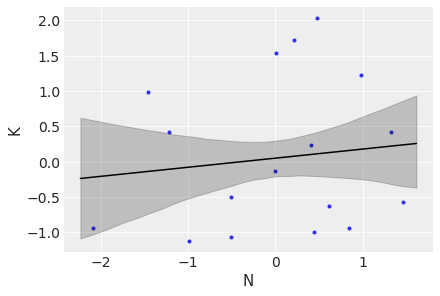

In [102]:
xseq = jnp.linspace(start=dcc.N.min() - 0.15, stop=dcc.N.max() + 0.15, num=30)
post = m5_5.sample_posterior(random.PRNGKey(1), p5_5, (1000,))
post_pred = Predictive(m5_5.model, post)(random.PRNGKey(2), N=xseq)
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=(5.5, 94.5), axis=0)
az.plot_pair(dcc[["N", "K"]].to_dict(orient="list"))
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

### Code 5.38

In [103]:
def model(M, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bM * M)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m5_6 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_6, optim.Adam(1), Trace_ELBO(), M=dcc.M.values, K=dcc.K.values)
p5_6, losses = svi.run(random.PRNGKey(0), 1000)
post = m5_6.sample_posterior(random.PRNGKey(1), p5_6, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:00<00:00, 1099.15it/s, init loss: 756.0300, avg. loss [951-1000]: 24.4211]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.06      0.16      0.06     -0.20      0.29    931.50      1.00
        bM     -0.28      0.20     -0.28     -0.61      0.03   1088.44      1.00
     mu[0]      0.18      0.18      0.19     -0.11      0.47    944.38      1.00
     mu[1]      0.02      0.16      0.02     -0.24      0.26    932.90      1.00
     mu[2]      0.02      0.16      0.02     -0.24      0.26    933.51      1.00
     mu[3]      0.14      0.17      0.15     -0.11      0.42    958.01      1.00
     mu[4]      0.36      0.27      0.36     -0.07      0.78    872.95      1.00
     mu[5]      0.65      0.45      0.65     -0.03      1.39    898.89      1.00
     mu[6]      0.42      0.31      0.43     -0.07      0.89    878.58      1.00
     mu[7]      0.49      0.35      0.50     -0.09      1.00    885.51      1.00
     mu[8]      0.22      0.20      0.23     -0.12      0.51    906.05      1.00
     mu[9]      0.10      0

### Code 5.39

In [104]:
def model(N, M, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bN = numpyro.sample("bN", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bN * N + bM * M)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m5_7 = AutoLaplaceApproximation(model)
svi = SVI(
    model, m5_7, optim.Adam(1), Trace_ELBO(), N=dcc.N.values, M=dcc.M.values, K=dcc.K.values
)
p5_7, losses = svi.run(random.PRNGKey(0), 1000)
post = m5_7.sample_posterior(random.PRNGKey(1), p5_7, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:01<00:00, 993.31it/s, init loss: 136.3944, avg. loss [951-1000]: 22.0707]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.06      0.13      0.06     -0.15      0.26   1049.96      1.00
        bM     -0.68      0.23     -0.68     -1.06     -0.32    837.54      1.00
        bN      0.65      0.25      0.66      0.25      1.06    885.39      1.00
     mu[0]     -0.99      0.47     -1.00     -1.72     -0.22    953.05      1.00
     mu[1]     -0.36      0.20     -0.35     -0.64     -0.03   1076.34      1.00
     mu[2]     -0.37      0.20     -0.36     -0.65     -0.03   1068.21      1.00
     mu[3]      0.28      0.16      0.28      0.03      0.52    967.73      1.00
     mu[4]      0.94      0.33      0.94      0.43      1.44    876.35      1.00
     mu[5]      0.53      0.39      0.53     -0.10      1.11   1015.67      1.00
     mu[6]      0.30      0.26      0.30     -0.10      0.73   1041.23      1.00
     mu[7]      0.30      0.30      0.30     -0.16      0.76   1039.12      1.00
     mu[8]      0.73      0

### Code 5.40

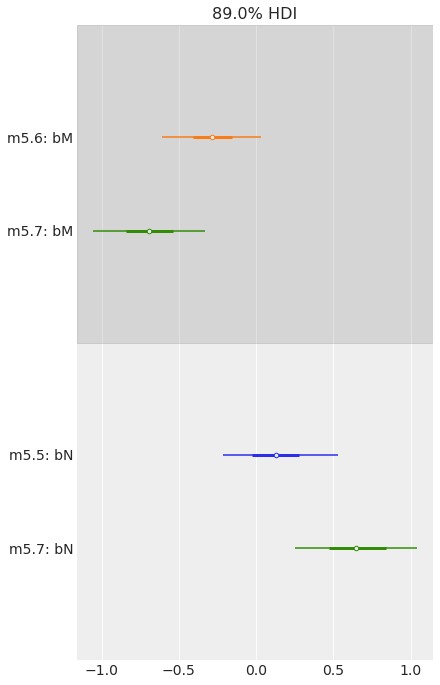

In [105]:
coeftab = {
    "m5.5": m5_5.sample_posterior(random.PRNGKey(1), p5_5, (1, 1000,)),
    "m5.6": m5_6.sample_posterior(random.PRNGKey(2), p5_6, (1, 1000,)),
    "m5.7": m5_7.sample_posterior(random.PRNGKey(3), p5_7, (1, 1000,)),
}
az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    var_names=["bM", "bN"],
    hdi_prob=0.89,
)
plt.show()

### Code 5.41

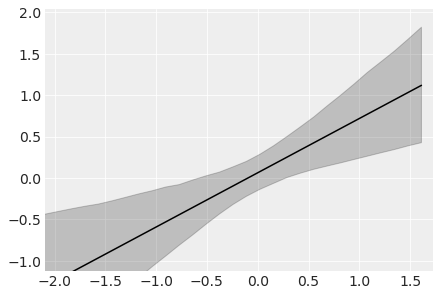

In [106]:
xseq = jnp.linspace(start=dcc.N.min() - 0.15, stop=dcc.N.max() + 0.15, num=30)
post = m5_7.sample_posterior(random.PRNGKey(1), p5_7, (1000,))
post_pred = Predictive(m5_7.model, post)(random.PRNGKey(2), M=0, N=xseq)
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=(5.5, 94.5), axis=0)
plt.subplot(xlim=(dcc.M.min(), dcc.M.max()), ylim=(dcc.K.min(), dcc.K.max()))
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

### Code 5.42

In [107]:
# M -> K <- N
# M -> N
n = 100
M = dist.Normal().sample(random.PRNGKey(0), (n,))
N = dist.Normal(M).sample(random.PRNGKey(1))
K = dist.Normal(N - M).sample(random.PRNGKey(2))
d_sim = pd.DataFrame({"K": K, "N": N, "M": M})

### Code 5.43

In [108]:
# M -> K <- N
# N -> M
n = 100
N = dist.Normal().sample(random.PRNGKey(0), (n,))
M = dist.Normal(N).sample(random.PRNGKey(1))
K = dist.Normal(N - M).sample(random.PRNGKey(2))
d_sim2 = pd.DataFrame({"K": K, "N": N, "M": M})

# M -> K <- N
# M <- U -> N
n = 100
N = dist.Normal().sample(random.PRNGKey(3), (n,))
M = dist.Normal(M).sample(random.PRNGKey(4))
K = dist.Normal(N - M).sample(random.PRNGKey(5))
d_sim3 = pd.DataFrame({"K": K, "N": N, "M": M})

### Code 5.44

In [109]:
dag5_7 = CausalGraphicalModel(
    nodes=["M", "K", "N"], edges=[("M", "K"), ("N", "K"), ("M", "N")]
)
coordinates = {"M": (0, 0.5), "K": (1, 1), "N": (2, 0.5)}
nodes = list(dag5_7.dag.nodes.keys())
edges = list(dag5_7.dag.edges.keys())
MElist = []
for i in range(2):
    for j in range(2):
        for k in range(2):
            try:
                new_dag = CausalGraphicalModel(
                    nodes=nodes,
                    edges=[
                        edges[0] if i == 0 else edges[0][::-1],
                        edges[1] if j == 0 else edges[1][::-1],
                        edges[2] if k == 0 else edges[2][::-1],
                    ],
                )
                MElist.append(new_dag)
            except:
                pass

### Code 5.45

In [110]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
height    544 non-null float64
weight    544 non-null float64
age       544 non-null float64
male      544 non-null int64
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


### Code 5.46

In [111]:
mu_female = dist.Normal(178, 20).sample(random.PRNGKey(0), (int(1e4),))
diff = dist.Normal(0, 10).sample(random.PRNGKey(1), (int(1e4),))
mu_male = dist.Normal(178, 20).sample(random.PRNGKey(2), (int(1e4),)) + diff
print_summary({"mu_female": mu_female, "mu_male": mu_male}, 0.89, False)


                 mean       std    median      5.5%     94.5%     n_eff     r_hat
  mu_female    178.21     20.22    178.24    147.19    211.84   9943.61      1.00
    mu_male    178.10     22.36    178.51    142.35    213.41  10190.57      1.00



### Code 5.47

In [112]:
d["sex"] = jnp.where(d.male.values == 1, 1, 0)
d.sex

0      1
1      0
2      0
3      1
4      0
      ..
539    1
540    1
541    0
542    1
543    1
Name: sex, Length: 544, dtype: int32

### Code 5.48

In [113]:
def model(sex, height):
    a = numpyro.sample("a", dist.Normal(178, 20).expand([len(set(sex))]))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a[sex]
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m5_8 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_8, optim.Adam(1), Trace_ELBO(), sex=d.sex.values, height=d.height.values)
p5_8, losses = svi.run(random.PRNGKey(0), 2000)
post = m5_8.sample_posterior(random.PRNGKey(1), p5_8, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 2000/2000 [00:01<00:00, 1429.82it/s, init loss: 5607.9028, avg. loss [1901-2000]: 2584.1565]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]    135.02      1.63    135.07    132.32    137.46    931.50      1.00
      a[1]    142.56      1.73    142.54    140.02    145.51   1111.51      1.00
     sigma     27.32      0.84     27.32     26.03     28.71    951.62      1.00



### Code 5.49

In [114]:
post = m5_8.sample_posterior(random.PRNGKey(1), p5_8, (1000,))
post["diff_fm"] = post["a"][:, 0] - post["a"][:, 1]
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]    135.02      1.63    135.07    132.32    137.46    931.50      1.00
      a[1]    142.56      1.73    142.54    140.02    145.51   1111.51      1.00
   diff_fm     -7.54      2.38     -7.47    -11.77     -4.32    876.56      1.00
     sigma     27.32      0.84     27.32     26.03     28.71    951.62      1.00



### Code 5.50

In [115]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d.clade.unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

### Code 5.51

In [116]:
d["clade_id"] = d.clade.astype("category").cat.codes

### Code 5.52

100%|██████████| 1000/1000 [00:00<00:00, 1226.95it/s, init loss: 94.6847, avg. loss [951-1000]: 36.2945]


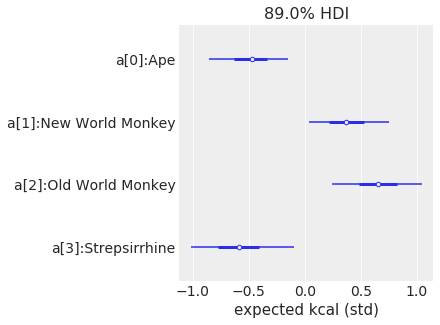

In [117]:
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())


def model(clade_id, K):
    a = numpyro.sample("a", dist.Normal(0, 0.5).expand([len(set(clade_id))]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a[clade_id]
    numpyro.sample("height", dist.Normal(mu, sigma), obs=K)


m5_9 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_9, optim.Adam(1), Trace_ELBO(), clade_id=d.clade_id.values, K=d.K.values)
p5_9, losses = svi.run(random.PRNGKey(0), 1000)
post = m5_9.sample_posterior(random.PRNGKey(1), p5_9, (1000,))
labels = ["a[" + str(i) + "]:" + s for i, s in enumerate(sorted(d.clade.unique()))]
az.plot_forest({"a": post["a"][None, ...]}, hdi_prob=0.89)
plt.gca().set(yticklabels=labels[::-1], xlabel="expected kcal (std)")
plt.show()

### Code 5.53

In [118]:
key = random.PRNGKey(63)
d["house"] = random.choice(key, jnp.repeat(jnp.arange(4), 8), d.shape[:1], False)

### Code 5.54

In [119]:
def model(clade_id, house, K):
    a = numpyro.sample("a", dist.Normal(0, 0.5).expand([len(set(clade_id))]))
    h = numpyro.sample("h", dist.Normal(0, 0.5).expand([len(set(house))]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a[clade_id] + h[house]
    numpyro.sample("height", dist.Normal(mu, sigma), obs=K)


m5_10 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m5_10,
    optim.Adam(1),
    Trace_ELBO(),
    clade_id=d.clade_id.values,
    house=d.house.values,
    K=d.K.values,
)
p5_10, losses = svi.run(random.PRNGKey(0), 1000)

100%|██████████| 1000/1000 [00:00<00:00, 1038.25it/s, init loss: 491.4240, avg. loss [951-1000]: 36.5554]


## 5H1

In [89]:
foxes = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/foxes.csv", sep=";")
d = foxes
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 5 columns):
group        116 non-null int64
avgfood      116 non-null float64
groupsize    116 non-null int64
area         116 non-null float64
weight       116 non-null float64
dtypes: float64(3), int64(2)
memory usage: 4.7 KB


,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [90]:
d["F"] = d["avgfood"].pipe(lambda x: (x - x.mean()) / x.std())
d["G"] = d["groupsize"].pipe(lambda x: (x - x.mean()) / x.std())
d["A"] = d["area"].pipe(lambda x: (x - x.mean()) / x.std())
d["W"] = d["weight"].pipe(lambda x: (x - x.mean()) / x.std())

In [91]:
def model(A, group=None, W=None):
    a_pop = numpyro.sample("a_pop", dist.Normal(0, 0.2))
    bA_pop = numpyro.sample("bA_pop", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    if group is not None:
        a_group = numpyro.sample("a_group", dist.Normal(0, 0.2).expand([len(set(group))]))
        bA_group = numpyro.sample("bA_group", dist.Normal(0, 0.5).expand([len(set(group))]))
        mu = numpyro.deterministic("mu", a_pop + bA_pop * A + a_group[group] + bA_group[group] * A)
    else:
        mu = numpyro.deterministic("mu", a_pop + bA_pop * A)
        
    numpyro.sample("W", dist.Normal(mu, sigma), obs=W)


m_5H1a = NUTS(model)
mcmc = MCMC(m_5H1a, num_samples=2000, num_warmup=2000, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key,
         group=d["group"].values - 1,
         A=d["A"].values,
         W=d["W"].values,)

post_5H1a = mcmc.get_samples()

print_summary(post_5H1a, 0.89, False)

sample: 100%|██████████| 4000/4000 [00:07<00:00, 557.85it/s, 7 steps of size 4.77e-01. acc. prob=0.83]



                  mean       std    median      5.5%     94.5%     n_eff     r_hat
  a_group[0]     -0.00      0.20     -0.01     -0.31      0.33   2498.28      1.00
  a_group[1]      0.04      0.20      0.05     -0.26      0.37   2571.90      1.00
  a_group[2]     -0.00      0.20     -0.01     -0.34      0.30   2794.26      1.00
  a_group[3]     -0.00      0.21      0.00     -0.31      0.33   2992.83      1.00
  a_group[4]      0.09      0.19      0.09     -0.21      0.39   2803.02      1.00
  a_group[5]      0.02      0.20      0.03     -0.31      0.33   2226.93      1.00
  a_group[6]      0.07      0.19      0.08     -0.23      0.37   2582.53      1.00
  a_group[7]     -0.00      0.20      0.00     -0.32      0.31   2898.21      1.00
  a_group[8]      0.07      0.19      0.07     -0.21      0.40   3233.51      1.00
  a_group[9]      0.02      0.20      0.02     -0.32      0.32   2204.15      1.00
 a_group[10]      0.01      0.20      0.01     -0.30      0.32   2549.82      1.00
 a_

In [98]:
import numpy as np

In [103]:
def model(G, group=None, W=None):
    a_pop = numpyro.sample("a_pop", dist.Normal(0, 0.2))
    bG_pop = numpyro.sample("bG_pop", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    if group is not None:
        n_groups = len(np.unique(group))
        a_group = numpyro.sample("a_group", dist.Normal(0, 0.2), sample_shape=(n_groups,))
        bG_group = numpyro.sample("bG_group", dist.Normal(0, 0.5), sample_shape=(n_groups,))
        mu = numpyro.deterministic("mu", a_pop + bG_pop * G + a_group[group] + bG_group[group] * G)
    else:
        mu = numpyro.deterministic("mu", a_pop + bG_pop * G)
        
    numpyro.sample("W", dist.Normal(mu, sigma), obs=W)


m_5H1b = NUTS(model)
mcmc = MCMC(m_5H1b, num_samples=2000, num_warmup=2000, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key,
         group=d["group"].values - 1,
         G=d["G"].values,
         W=d["W"].values,)

post_5H1b = mcmc.get_samples()

print_summary(post_5H1b, 0.89, False)

sample: 100%|██████████| 4000/4000 [00:07<00:00, 544.97it/s, 15 steps of size 4.18e-01. acc. prob=0.85]



                  mean       std    median      5.5%     94.5%     n_eff     r_hat
  a_group[0]     -0.03      0.20     -0.03     -0.36      0.28   3019.57      1.00
  a_group[1]      0.03      0.20      0.02     -0.29      0.34   2651.66      1.00
  a_group[2]     -0.02      0.20     -0.01     -0.31      0.33   2438.61      1.00
  a_group[3]     -0.01      0.21     -0.01     -0.34      0.32   2762.28      1.00
  a_group[4]      0.07      0.19      0.08     -0.23      0.36   2825.41      1.00
  a_group[5]     -0.00      0.20      0.00     -0.33      0.32   2134.87      1.00
  a_group[6]      0.04      0.19      0.04     -0.24      0.34   2314.04      1.00
  a_group[7]     -0.02      0.20     -0.02     -0.35      0.29   2638.18      1.00
  a_group[8]      0.05      0.20      0.05     -0.26      0.36   2200.18      1.00
  a_group[9]      0.01      0.20      0.02     -0.30      0.33   2555.65      1.00
 a_group[10]     -0.01      0.19     -0.00     -0.33      0.26   2757.62      1.00
 a_

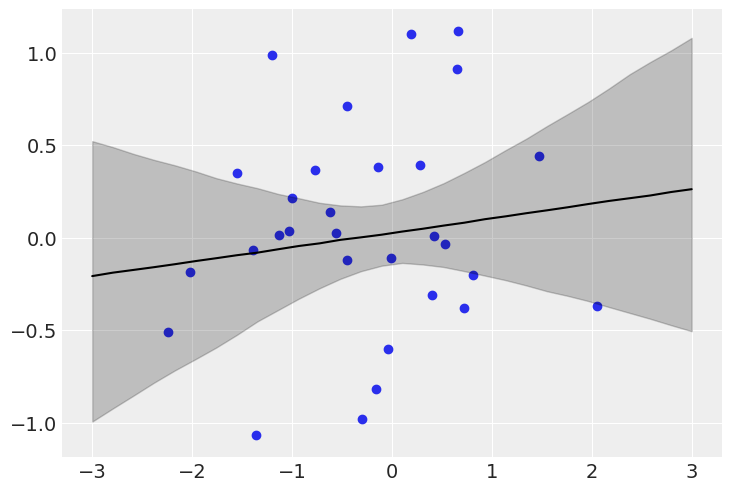

In [126]:
A_seq = jnp.linspace(-3, 3, num=30)
post_pred = Predictive(m_5H1a.model, post_5H1a)(random.PRNGKey(2), A=A_seq)

mu_PI = jnp.percentile(post_pred["mu"], [50, 5.5, 94.5], axis=0)

plt.scatter(d.groupby("group").mean()["A"], d.groupby("group").mean()["W"].values)
plt.plot(A_seq, mu_PI[0], "k-")
plt.fill_between(A_seq, mu_PI[1], mu_PI[2], color="k", alpha=0.2)
plt.show()

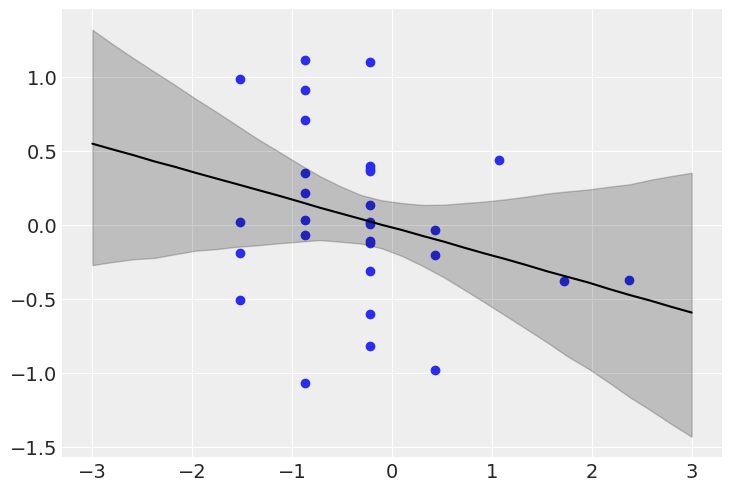

In [125]:
G_seq = jnp.linspace(-3, 3, num=30)
post_pred = Predictive(m_5H1b.model, post_5H1b)(random.PRNGKey(2), G=G_seq)

mu_PI = jnp.percentile(post_pred["mu"], [50, 5.5, 94.5], axis=0)

plt.scatter(d.groupby("group").mean()["G"], d.groupby("group").mean()["W"].values)
plt.plot(G_seq, mu_PI[0], "k-")
plt.fill_between(G_seq, mu_PI[1], mu_PI[2], color="k", alpha=0.2)
plt.show()

### 5H2

In [106]:
def model(A, G, n_groups=d["group"].nunique(), group=None, W=None):
    a_pop_loc = numpyro.sample("a_pop_loc", dist.Normal(0, 0.2))
    bA_pop_loc = numpyro.sample("bA_pop_loc", dist.Normal(0, 0.5))
    bG_pop_loc = numpyro.sample("bG_pop_loc", dist.Normal(0, 0.5))
    pop_effects_loc = a_pop_loc + bA_pop_loc * A + bG_pop_loc * G
            
    a_pop_scale = numpyro.sample("a_pop_scale", dist.Normal(1, 0.5))
    bA_pop_scale = numpyro.sample("bA_pop_scale", dist.Normal(0, 0.5))
    bG_pop_scale = numpyro.sample("bG_pop_scale", dist.Normal(0, 0.5))
    pop_effects_scale = a_pop_scale + bA_pop_scale * A + bG_pop_scale * G
    
    if group is not None:
        if n_groups is None:
            n_groups = len(np.unique(group))
        a_group_loc = numpyro.sample("a_group_loc", dist.Normal(0, 0.2), sample_shape=(n_groups,))
        bA_group_loc = numpyro.sample("bA_group_loc", dist.Normal(0, 0.5), sample_shape=(n_groups,))
        bG_group_loc = numpyro.sample("bG_group_loc", dist.Normal(0, 0.5), sample_shape=(n_groups,))
        group_effects_loc = a_group_loc[group] + bA_group_loc[group] * A + bG_group_loc[group] * G
        loc = numpyro.deterministic("loc", pop_effects_loc + group_effects_loc)

        
        a_group_scale = numpyro.sample("a_group_scale", dist.Normal(0, 0.5), sample_shape=(n_groups,))
        bA_group_scale = numpyro.sample("bA_group_scale", dist.Normal(0, 0.5), sample_shape=(n_groups,))
        bG_group_scale = numpyro.sample("bG_group_scale", dist.Normal(0, 0.5), sample_shape=(n_groups,))
        group_effects_scale = a_group_scale[group] + bA_group_scale[group] * A + bG_group_scale[group] * G
        scale = numpyro.deterministic("scale", jax.nn.softplus(pop_effects_scale + group_effects_scale))
    else:
        loc = numpyro.deterministic("loc", pop_effects_loc)
        scale = numpyro.deterministic("scale", jax.nn.softplus(pop_effects_scale))
    
    numpyro.sample("W", dist.Normal(loc, scale), obs=W)


In [107]:
m_5H2 = NUTS(model)
mcmc = MCMC(m_5H2, num_samples=5000, num_warmup=5000, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key,
         group=d["group"].values - 1,
         n_groups=d["group"].nunique(),
         A=d["A"].values,
         G=d["G"].values,
         W=d["W"].values,)

post_5H2 = mcmc.get_samples()

print_summary(post_5H2, 0.89, False)


sample: 100%|██████████| 10000/10000 [00:24<00:00, 401.53it/s, 63 steps of size 7.66e-02. acc. prob=0.95]



                        mean       std    median      5.5%     94.5%     n_eff     r_hat
    a_group_loc[0]     -0.01      0.20     -0.00     -0.33      0.29  12228.46      1.00
    a_group_loc[1]      0.02      0.20      0.02     -0.29      0.34  11010.47      1.00
    a_group_loc[2]     -0.01      0.20     -0.01     -0.33      0.31  13250.02      1.00
    a_group_loc[3]     -0.00      0.20     -0.00     -0.31      0.31  11810.99      1.00
    a_group_loc[4]      0.05      0.20      0.05     -0.27      0.36  11509.58      1.00
    a_group_loc[5]      0.01      0.19      0.01     -0.30      0.32  11002.91      1.00
    a_group_loc[6]      0.03      0.19      0.03     -0.27      0.35  11294.02      1.00
    a_group_loc[7]      0.00      0.20      0.00     -0.32      0.31  10281.54      1.00
    a_group_loc[8]      0.02      0.20      0.03     -0.28      0.34  11826.01      1.00
    a_group_loc[9]      0.01      0.20      0.02     -0.29      0.33  12597.25      1.00
   a_group_loc[10]  

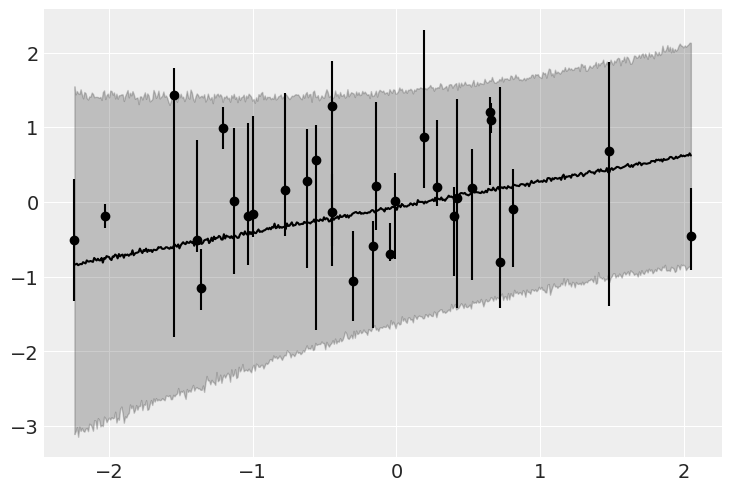

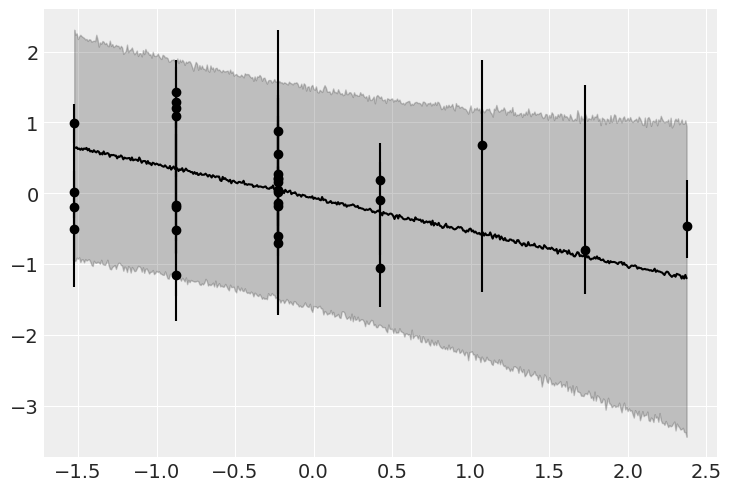

In [142]:
A_seq = jnp.linspace(d.groupby("group").mean()["A"].min(),
                     d.groupby("group").mean()["A"].max(),
                     num=500)
G_seq = jnp.linspace(d.groupby("group").mean()["G"].min(),
                     d.groupby("group").mean()["G"].max(),
                     num=500)

post_pred = Predictive(m_5H2.model, post_5H2)(random.PRNGKey(2), G=0, A=A_seq, group=None)

mu_PI = jnp.percentile(post_pred["W"], [50, 5.5, 94.5], axis=0)

#plt.scatter(d.groupby("group").mean()["A"].values, d.groupby("group").mean()["W"].values)
plt.errorbar(
    x=d.groupby("group").median()["A"].values,
    y=d.groupby("group").median()["W"].values,
    xerr=np.stack([
        d.groupby("group").median()["A"].values - d.groupby("group").quantile(0.055)["A"].values,
        d.groupby("group").quantile(0.945)["A"].values - d.groupby("group").median()["A"].values,
    ]),
    yerr=np.stack([
        d.groupby("group").median()["W"].values - d.groupby("group").quantile(0.055)["W"].values,
        d.groupby("group").quantile(0.945)["W"].values - d.groupby("group").median()["W"].values,
    ]),
    fmt='ko'
)


plt.plot(A_seq, mu_PI[0], "k-")
plt.fill_between(A_seq, mu_PI[1], mu_PI[2], color="k", alpha=0.2)
plt.show()

post_pred = Predictive(m_5H2.model, post_5H2)(random.PRNGKey(2), G=G_seq, A=0, group=None)

mu_PI = jnp.percentile(post_pred["W"], [50, 5.5, 94.5], axis=0)

#plt.scatter(d.groupby("group").mean()["G"].values, d.groupby("group").mean()["W"].values)
plt.errorbar(
    x=d.groupby("group").median()["G"].values,
    y=d.groupby("group").median()["W"].values,
    xerr=np.stack([
        d.groupby("group").median()["G"].values - d.groupby("group").quantile(0.055)["G"].values,
        d.groupby("group").quantile(0.945)["G"].values - d.groupby("group").median()["G"].values,
    ]),
    yerr=np.stack([
        d.groupby("group").median()["W"].values - d.groupby("group").quantile(0.055)["W"].values,
        d.groupby("group").quantile(0.945)["W"].values - d.groupby("group").median()["W"].values,
    ]),
    fmt='ko'
)
plt.plot(G_seq, mu_PI[0], "k-")
plt.fill_between(G_seq, mu_PI[1], mu_PI[2], color="k", alpha=0.2)
plt.show()



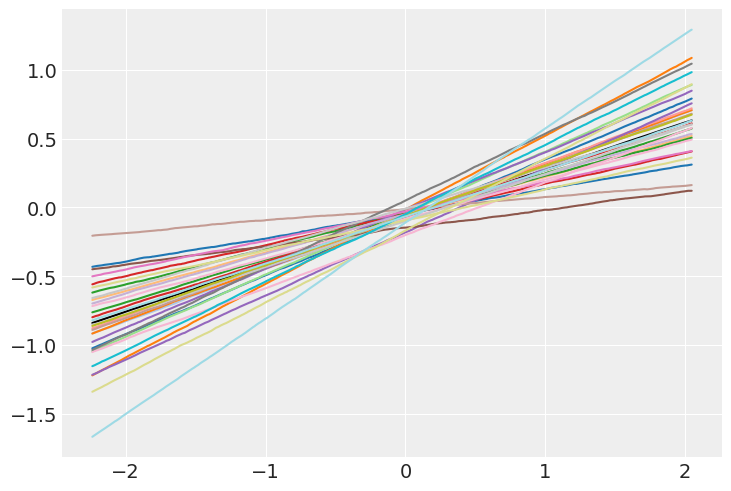

In [129]:
color = plt.cm.tab20(np.linspace(0, 1, 30))
post_pred = Predictive(m_5H2.model, post_5H2)(random.PRNGKey(2), G=0, A=A_seq, group=None)

mu_PI = jnp.percentile(post_pred["loc"], [50, 5.5, 94.5], axis=0)

plt.plot(A_seq, mu_PI[0], "k-")

for group in range(30):
    post_pred = Predictive(m_5H2.model, post_5H2)(random.PRNGKey(2), G=0, A=A_seq, group=group)

    mu_PI = jnp.percentile(post_pred["loc"], [50, 5.5, 94.5], axis=0)

    plt.plot(A_seq, mu_PI[0], "-", color=color[group])
    #plt.fill_between(A_seq, mu_PI[1], mu_PI[2], color=color[group], alpha=0.2)
plt.show()


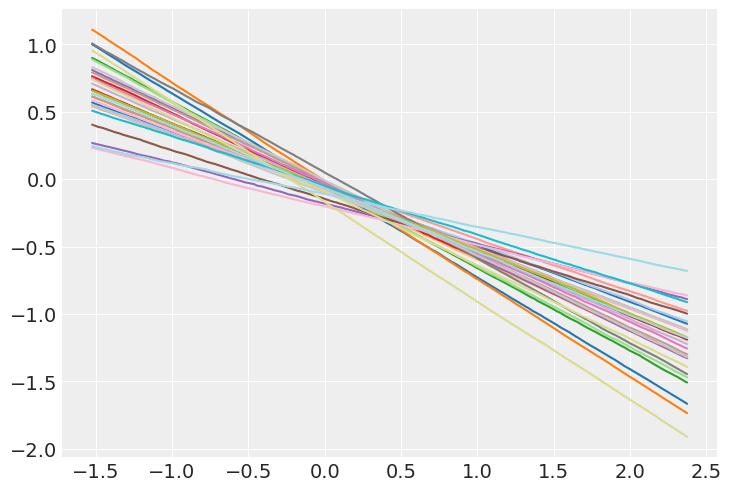

In [130]:
color = plt.cm.tab20(np.linspace(0, 1, 30))
for group in range(30):
    post_pred = Predictive(m_5H2.model, post_5H2)(random.PRNGKey(2), G=G_seq, A=0, group=group)

    mu_PI = jnp.percentile(post_pred["loc"], [50, 5.5, 94.5], axis=0)

    plt.plot(G_seq, mu_PI[0], "-", color=color[group])
    #plt.fill_between(A_seq, mu_PI[1], mu_PI[2], color=color[group], alpha=0.2)
plt.show()
